# MLflow Training Tutorial

This `train.pynb` Jupyter notebook predicts the quality of wine using [sklearn.linear_model.ElasticNet](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).  

> This is the Jupyter notebook version of the `train.py` example

Attribution
* The data set used in this example is from http://archive.ics.uci.edu/ml/datasets/Wine+Quality
* P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
* Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.


In [49]:
import logging
import warnings

import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [50]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [51]:
def savefig(rmse, mae, r2, artifact_path):
    df = pd.DataFrame()
    df['mae'] = [mae.round(3)]
    df['rmse'] = [rmse.round(3)]
    df['r2'] = [r2.round(3)]

    fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
    fig.savefig(artifact_path+"/metrics.png")  

In [52]:
def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

### Run Server on Terminal
mlflow server --backend-store-uri 'sqlite:///mlflow.db' --artifacts-destination mlflow/artifacts_root --serve-artifacts

In [53]:
#export MLFLOW_TRACKING_URI = http://127.0.0.1:5000/
# print(os.getenv('MLFLOW_TRACKING_URI'))
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
artifact_path = "artifacts"

In [54]:
# Wine Quality Sample
def run_train(in_alpha, in_l1_ratio, train_x, test_x, train_y, test_y):

    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Set default values if no alpha is provided
    alpha = 0.5 if float(in_alpha) is None else float(in_alpha)

    # Set default values if no l1_ratio is provided
    l1_ratio = 0.5 if float(in_l1_ratio) is None else float(in_l1_ratio)

    # Useful for multiple runs (only doing one run in this sample notebook)
    with mlflow.start_run():
        # Execute ElasticNet
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        # Evaluate Metrics
        predicted_qualities = lr.predict(test_x)
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        # Print out metrics
        print(f"Elasticnet model (alpha={alpha:f}, l1_ratio={l1_ratio:f}):")
        print(f"  RMSE: {rmse}")
        print(f"  MAE: {mae}")
        print(f"  R2: {r2}")

        # Infer model signature
        predictions = lr.predict(train_x)
        signature = infer_signature(train_x, predictions)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        test_x.to_csv(artifact_path+"/test.csv")
        train_x.to_csv(artifact_path+"/train.csv")
        test_y.to_csv(artifact_path+"/y_test.csv")
        pd.Series(predicted_qualities).to_csv(artifact_path+"/y_predict.csv")

        savefig(rmse,mae,r2, artifact_path)

        mlflow.log_artifact(artifact_path+"/test.csv", artifact_path="data")
        mlflow.log_artifact(artifact_path+"/train.csv", artifact_path="data")
        mlflow.log_artifact(artifact_path+"/y_test.csv", artifact_path="data")
        mlflow.log_artifact(artifact_path+"/y_predict.csv", artifact_path="data")
        mlflow.log_artifact(artifact_path+"/metrics.png", artifact_path="images")
        mlflow.set_tag('Train Size', 0.75)
        mlflow.set_tag('Test Size', 0.25)

        mlflow.sklearn.log_model(lr, "model", signature=signature)

In [55]:
data = pd.read_csv("data/winequality-red.csv", sep=";")

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

Elasticnet model (alpha=0.050000, l1_ratio=0.100000):
  RMSE: 0.6988443453576301
  MAE: 0.5344714838049984
  R2: 0.3080182508046694


2024/09/05 15:31:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-panda-135 at: http://127.0.0.1:5000/#/experiments/0/runs/5113ce1265f74f2e86e1759af3385241.
2024/09/05 15:31:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


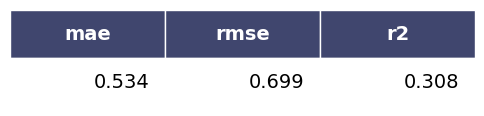

In [56]:
run_train(0.05, 0.1, train_x, test_x, train_y, test_y)

Elasticnet model (alpha=0.200000, l1_ratio=0.200000):
  RMSE: 0.7336400911821402
  MAE: 0.5643841279275427
  R2: 0.2373946606358417


2024/09/05 15:31:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-fish-982 at: http://127.0.0.1:5000/#/experiments/0/runs/522e2f25c53640f69d15d35aef902eee.
2024/09/05 15:31:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


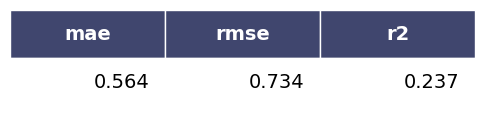

In [57]:
run_train(0.2, 0.2, train_x, test_x, train_y, test_y)

### Logged Model

In [62]:
logged_model = 'runs:/5113ce1265f74f2e86e1759af3385241/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

RMSE: 0.699 | MAE: 0.534 | R2: 0.308


### Version Model

In [65]:
model_name = "ElasticnetWineModel"
version = "1"
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{version}")
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'Version: {version} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

2024/09/05 15:36:12 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.16.0, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Version: 1 | RMSE: 0.833 | MAE: 0.668 | R2: 0.018


### Alias

In [68]:
model_name = "ElasticnetWineModel"
model_version_alias = 'best'
# Get the model version using a model URI
model_uri = f"models:/{model_name}@{model_version_alias}"
loaded_model = mlflow.sklearn.load_model(model_uri)
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'Version: {version} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

Version: 1 | RMSE: 0.699 | MAE: 0.534 | R2: 0.308
